# Convolution basics

The notebook will illustrate:
1. single 1D convolution
2. 2D convolutional layer from 1 to many channels
3. 2D convolutional layer from many to many channels

There is an Exercise at the end of the notebook.

In [1]:
import torch
from torch import nn

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from torchvision import datasets
mnist_train = datasets.MNIST(root='data', train=True, download=True)       # train data only
trainimages = mnist_train.data

100%|██████████| 9912422/9912422 [00:00<00:00, 89705097.50it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 56631927.92it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32894126.42it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10231218.46it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
def montage(imgstack):
    nimg = imgstack.size(dim = 0)
    width = int(np.ceil(np.sqrt(nimg)))   # compute a roughly square layout for the panels
    height = int(np.ceil(nimg / width))
    for i in range(nimg):
        ax = plt.subplot(height, width, i+1)
        plt.matshow(imgstack[i], fignum = False)    # Having to remember fignum can be disadvantage of matshow
        plt.axis('off')

## 1D convolutional layer
We start by creating an instance of `nn.Conv1d` that computes a single convolution from one channel to one channel.\
This is hopefully instructive but admittedly cumbersome because `nn.Conv1d` is generally used to go from many channels to many channels.

### Create a kernel that looks like one tooth of a sawtooth function

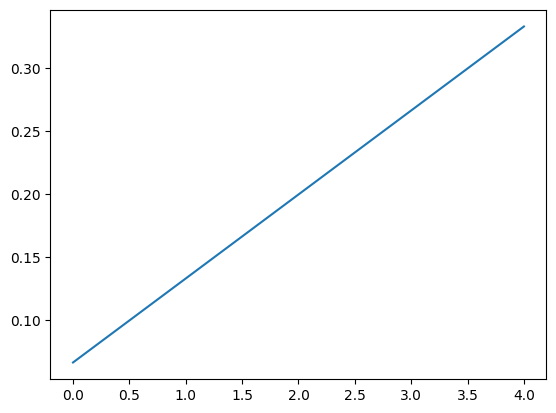

In [4]:
w = torch.arange(1, 6).float()
w /= torch.sum(w)    # normalize to have sum equal to one
plt.plot(w)

### Put the kernel in a 1D convolutional layer from one channel to one channel.
Note we have to turn `w` into a tensor with dimensions (1, 1, 5)

In [5]:
conv1 = nn.Conv1d(1, 1, 5, padding='same')
conv1.weight = nn.Parameter(w[None, None])    # alternatively w.view(1, 1, -1)
conv1.requires_grad_(False)

Conv1d(1, 1, kernel_size=(5,), stride=(1,), padding=same)

### Apply the convolutional layer to a delta function stimulus
Note that we have to turn `s` into a tensor with dimensions (1, 100), to indicate a single channel.

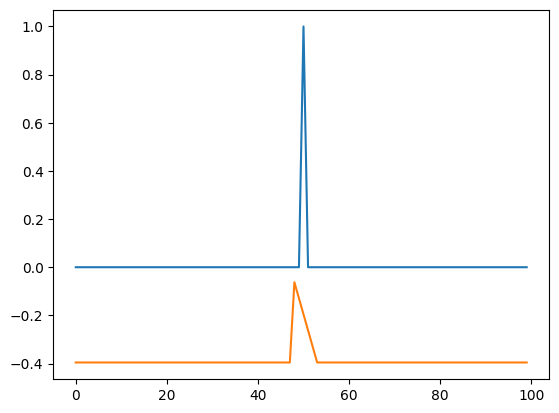

In [7]:
s = torch.zeros(100)   # define a stimulus of length 100
s[50] = 1              # put a delta function at the center
r = conv1(s[None])     # apply the convolution
plt.plot(s)            # plot the stimulus
plt.plot(r[0])         # and the response

### Aside for signal processing buffs
If you compare the two plots above, you'll see that the response to the delta function stimulus (impulse response) is flipped relative to the `w`. That's because the PyTorch convolution is actually correlation. You can see this by comparing with the [NumPy convolution](https://numpy.org/doc/stable/reference/generated/numpy.convolve.html).\
(Alternatively, you could say that the flipped kernel is stored, which is analogous to transposing the channels.)

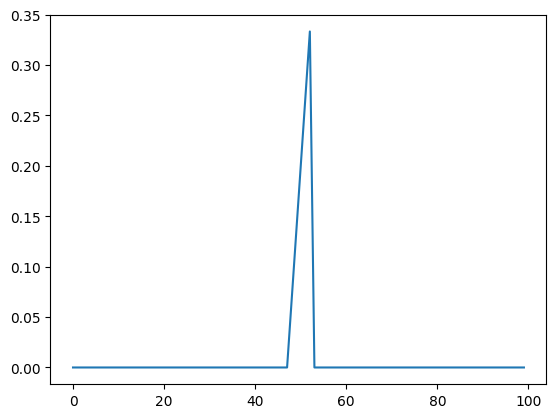

In [8]:
plt.plot(np.convolve(s, w, mode = 'same'))

## Oriented bar detectors: example of one to many convolutional layer

### Create kernels for detecting horizontal, diagonal, vertical, diagonal bars

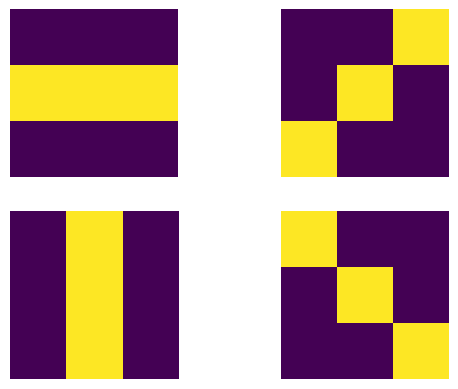

In [9]:
w = torch.tensor([
    [
        [-1, -1, -1],
        [1, 1, 1],
        [-1, -1, -1]
    ],
    [
        [-1, -1, 1],
        [-1, 1, -1],
        [1, -1, -1]
    ],
    [
        [-1, 1, -1],
        [-1, 1, -1],
        [-1, 1, -1]
    ],
    [
        [1, -1, -1],
        [-1, 1, -1],
        [-1, -1, 1]
    ]
]).float()
montage(w)
w += 1/3    # normalize so that mean value of w is zero

### insert kernels in 2D convolutional layer from one channel to four channels

Note we have to turn `w` into a tensor with dimensions (4, 1, 3, 3)

In [10]:
conv2 = nn.Conv2d(1, 4, 3, padding='same')
conv2.weight = nn.Parameter(w[:, None, :, :])
conv2.requires_grad_(False)

Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)

We turn `trainimages[2]` into a tensor with dimensions (1, 28, 28) because it's a single channel.\
Then we apply the convolutional layer.\
The left channels behave like feature maps for horizontal and vertical bars.
The right channels have many more active neurons, \
but the most active neurons do seem to detect diagonal bars of the appropriate orientation.

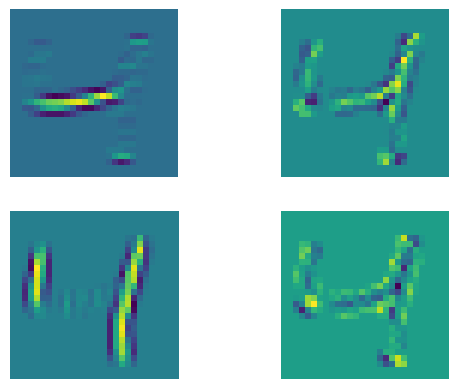

In [11]:
montage(conv2(trainimages[2][None]/255))

### Add a rectification nonlinearity

`nn.Sequential` is used to chain a convolutional layer and a rectification layer.\
`model[0]` is used to access the convolutional layer.

In [12]:
model = nn.Sequential(
    nn.Conv2d(1, 4, 3, padding='same'),
    nn.ReLU()
)
model[0].weight = nn.Parameter(w[:, None, :, :])
model[0].bias = nn.Parameter(torch.zeros(4))
model.requires_grad_(False)

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
)

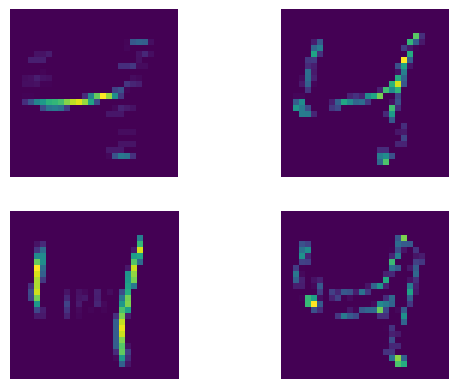

In [13]:
montage(model(trainimages[2][None]/255))

### Add a max pooling layer

In [14]:
model = nn.Sequential(
    nn.Conv2d(1, 4, 3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2)
)
model[0].weight = nn.Parameter(w[:, None, :, :])
model[0].bias = nn.Parameter(torch.zeros(4))
model.requires_grad_(False)

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

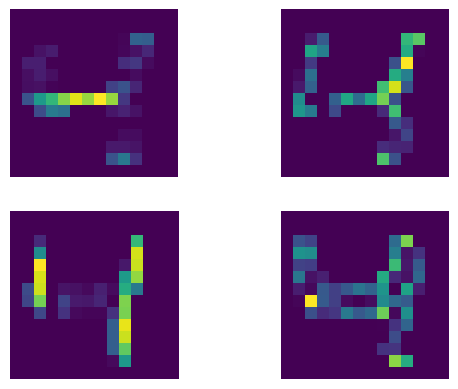

In [15]:
montage(model(trainimages[2][None]/255))

## Convolutional layer from m channels to n channels

Create a 2D convolutional layer from 4 channels to 6 channels,\
using the default random initialization for weights and biases.

In [16]:
conv = nn.Conv2d(4, 6, 3)
conv.requires_grad_(False)

Conv2d(4, 6, kernel_size=(3, 3), stride=(1, 1))

Convert five training images to tensor with dimensions (5, 1, 28, 28).\
Then apply the previous model. Can you predict the shape of `out` and `conv(out)`?

In [18]:
out = model(trainimages[0:5][:, None]/255)

In [19]:
out.shape

torch.Size([5, 4, 14, 14])

In [20]:
conv(out).shape

torch.Size([5, 6, 12, 12])

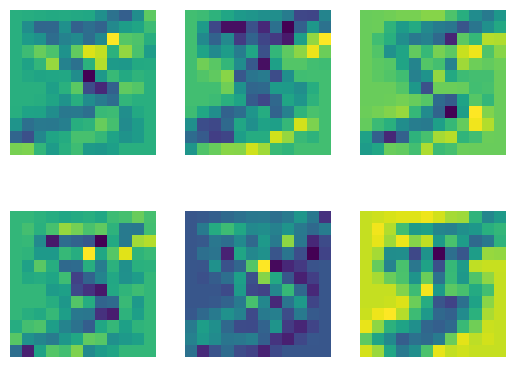

In [21]:
montage(conv(out)[0])

# Exercise

### Background
First we will create a single layer convolutional net that detects the following pattern in binary images.\
(When detecting this pattern, it doesn't matter what the input is outside the $4\times 4$ block.)

In [22]:
trigger = torch.tensor([
   [1, 1, 1, 1],
   [1, 0, 0, 1],
   [1, 0, 0, 1],
   [1, 1, 1, 1]
]).float()

Here are two test images. The right image has the trigger pattern inserted.\
The left image is the same, but the trigger pattern has been corrupted by filling it in.

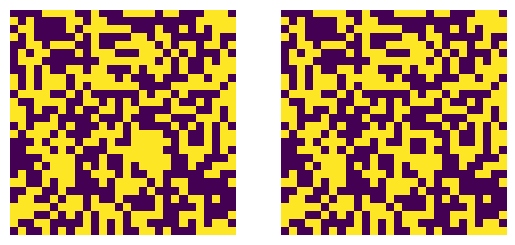

In [23]:
torch.manual_seed(485)
testimages = torch.zeros(2, 28, 28)
testimages[1] = (torch.rand(28, 28) > 0.5).float()
testimages[1, 15:19, 15:19] = trigger
testimages[0, :, :] = testimages[1, :, :]
testimages[0, 16:18, 16:18] = 1
montage(testimages)

Here is the convolutional layer (without the nonlinear activation)

In [24]:
w = torch.tensor([
   [1, 1, 1, 1],
   [1, -1, -1, 1],
   [1, -1, -1, 1],
   [1, 1, 1, 1]
]).float()
single = nn.Conv2d(1, 1, 4)
single.weight = nn.Parameter(w[None, None])
single.bias = nn.Parameter(torch.tensor([-11.5]))
single.requires_grad_(False)

print(single.output_padding)


(0, 0)


We apply the convolutional layer and threshold the result with the Heaviside step function.\
In the left image, all neurons are silent because the trigger pattern is not present in the test image.\
In the right image, only the correct neuron was triggered by the pattern.

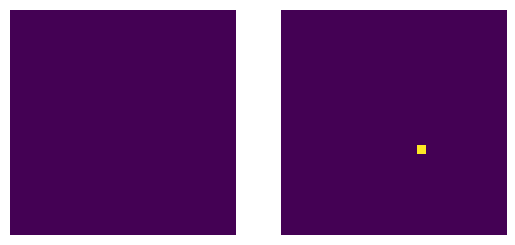

In [25]:
binaryoutput = single(testimages[:, None, :, :]) > 0
montage(binaryoutput.squeeze())

### Challenge

Design a convolutional net that performs the same computation.\
Here's the catch: you are allowed to use only kernels up to $3\times 3$ but no larger.\
You can assume that all images are binary.

In [26]:
first = torch.tensor(
   [[1, 1, 1],
   [1, -9, 1],
   [1, 1, 1]]
   ).float()

second = torch.tensor(
    [[1, 1],
     [1, 1]]
).float()


Show output on the test images

In [27]:
modelM = nn.Sequential(
    nn.Conv2d(1, 1, 3, padding=1, stride = 1),
    nn.Conv2d(1, 1, 2, stride = 1)
)

modelM[0].weight = nn.Parameter(first[None, None, :, :])
modelM[0].bias = nn.Parameter(torch.tensor([0.0]))
modelM[0].requires_grad_(False)

modelM[1].weight = nn.Parameter(second[None, None, :, :])
modelM[1].bias = nn.Parameter(torch.tensor([-19.5]))
modelM[1].requires_grad_(False)


Conv2d(1, 1, kernel_size=(2, 2), stride=(1, 1))

Show the kernels and biases for each layer

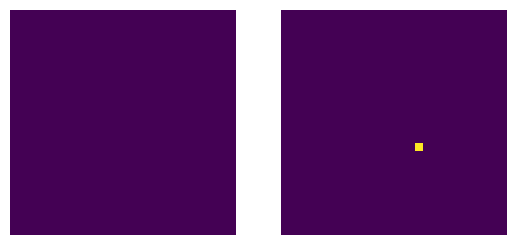

In [28]:
binaryoutputM = modelM(testimages[:, None, :, :]) > 0

montage(binaryoutputM.squeeze())
